1. Download Crime Data
2. Preview Data
3. Visualisation
4. Reconstruct Data


1. Download Crime Data

In [1]:
from urllib.request import urlretrieve
import os

In [2]:
# make directory
output_relative_dir = '../data/raw/'

if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    

target_dir = 'crime'
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

# download file
url = 'https://files.crimestatistics.vic.gov.au/2022-09/Data_Tables_LGA_Criminal_Incidents_Year_Ending_June_2022.xlsx' 

print(f"Begin download crime data")
output_dir = f'{output_relative_dir}{target_dir}/Data_Tables_LGA_Criminal_Incidents_Year_Ending_June_2022.xlsx'
zip_path, _ = urlretrieve(url,output_dir)
print(f"complete download crime data")


Begin download crime data
complete download crime data


2. Preview Data
    a. read and select features
    
    b. crime data by suburb
    c. crime data by lga
    d. rent data preprocessing

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
# a. read and select feature

df_Criminal_Incidents = pd.read_excel(
    '../data/raw/crime/Data_Tables_LGA_Criminal_Incidents_Year_Ending_June_2022.xlsx', 
    engine='openpyxl', sheet_name='Table 03')

df_Crime = df_Criminal_Incidents[['Year', 'Postcode', 'Suburb/Town Name', 'Incidents Recorded']]



In [ ]:
# b. count the total crime cases by suburbs

df_crime_by_suburb = pd.DataFrame(
    columns=['Year', 'Suburb/Town Name', 'total criminal incidents'])

# df_crime_by_suburb.append({'year': 2022, 'Suburb/Town Name': 'x', 'total criminal incidents': 1}, ignore_index=True)

for year in df_Crime['Year'].unique():
    for name in df_Crime[df_Crime['Year'] == year]['Suburb/Town Name'].unique():
        count = df_Crime[(df_Crime['Year'] == year) & (df_Crime['Suburb/Town Name'] == name)] ['Incidents Recorded'].sum()
        df_crime_by_suburb = df_crime_by_suburb.append({'Year': year, 'Suburb/Town Name': name, 'total criminal incidents': count}, ignore_index=True)

In [6]:
# crime rate by LGA
df_Criminal_Incidents_LGA = pd.read_excel(
    '../data/raw/crime/Data_Tables_LGA_Criminal_Incidents_Year_Ending_June_2022.xlsx', 
    engine='openpyxl', sheet_name='Table 01')

df_Criminal_Incidents_LGA = df_Criminal_Incidents_LGA[
    ['Year', 'Local Government Area','Incidents Recorded', 'Rate per 100,000 population']]

df_Criminal_Incidents_LGA = df_Criminal_Incidents_LGA.replace(r"^ +| +$", r"", regex=True)

In [18]:
# c. preprocess rent data
df_property = pd.read_csv('../data/raw/property.csv')
df_property.columns

df_property_filtered = df_property[['suburb', 'rent_price_', 'rent_date']]

df_property_filtered.dropna(inplace=True)

df_property_filtered['rent_date'] = pd.to_datetime(df_property_filtered['rent_date'])

min = pd.Timestamp('2013-01-01')
max = pd.Timestamp('2022-12-31')

df_property_filtered[(min<=df_property_filtered['rent_date']) & (df_property_filtered['rent_date'] <= max)]

df_property_filtered['rent_price_'] = df_property_filtered['rent_price_'].astype('str')
df_property_filtered['rent_price_'] = df_property_filtered['rent_price_'].str.extract(r'([0-9]+)')
df_property_filtered['rent_price_'] = df_property_filtered['rent_price_'].astype(float)

/tmp/ipykernel_5723/1500583985.py:2: DtypeWarning: Columns (5,6,7,10,11,16,18,22,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_property = pd.read_csv('../data/raw/property.csv')
/tmp/ipykernel_5723/1500583985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_property_filtered.dropna(inplace=True)
/tmp/ipykernel_5723/1500583985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_property_filtered['rent_date'] = pd.to_datetime(df_property_filtered['rent_date'])
/tmp/ipykernel_5723/1500583985.py:16: SettingWithCopyWarn

<AxesSubplot:>

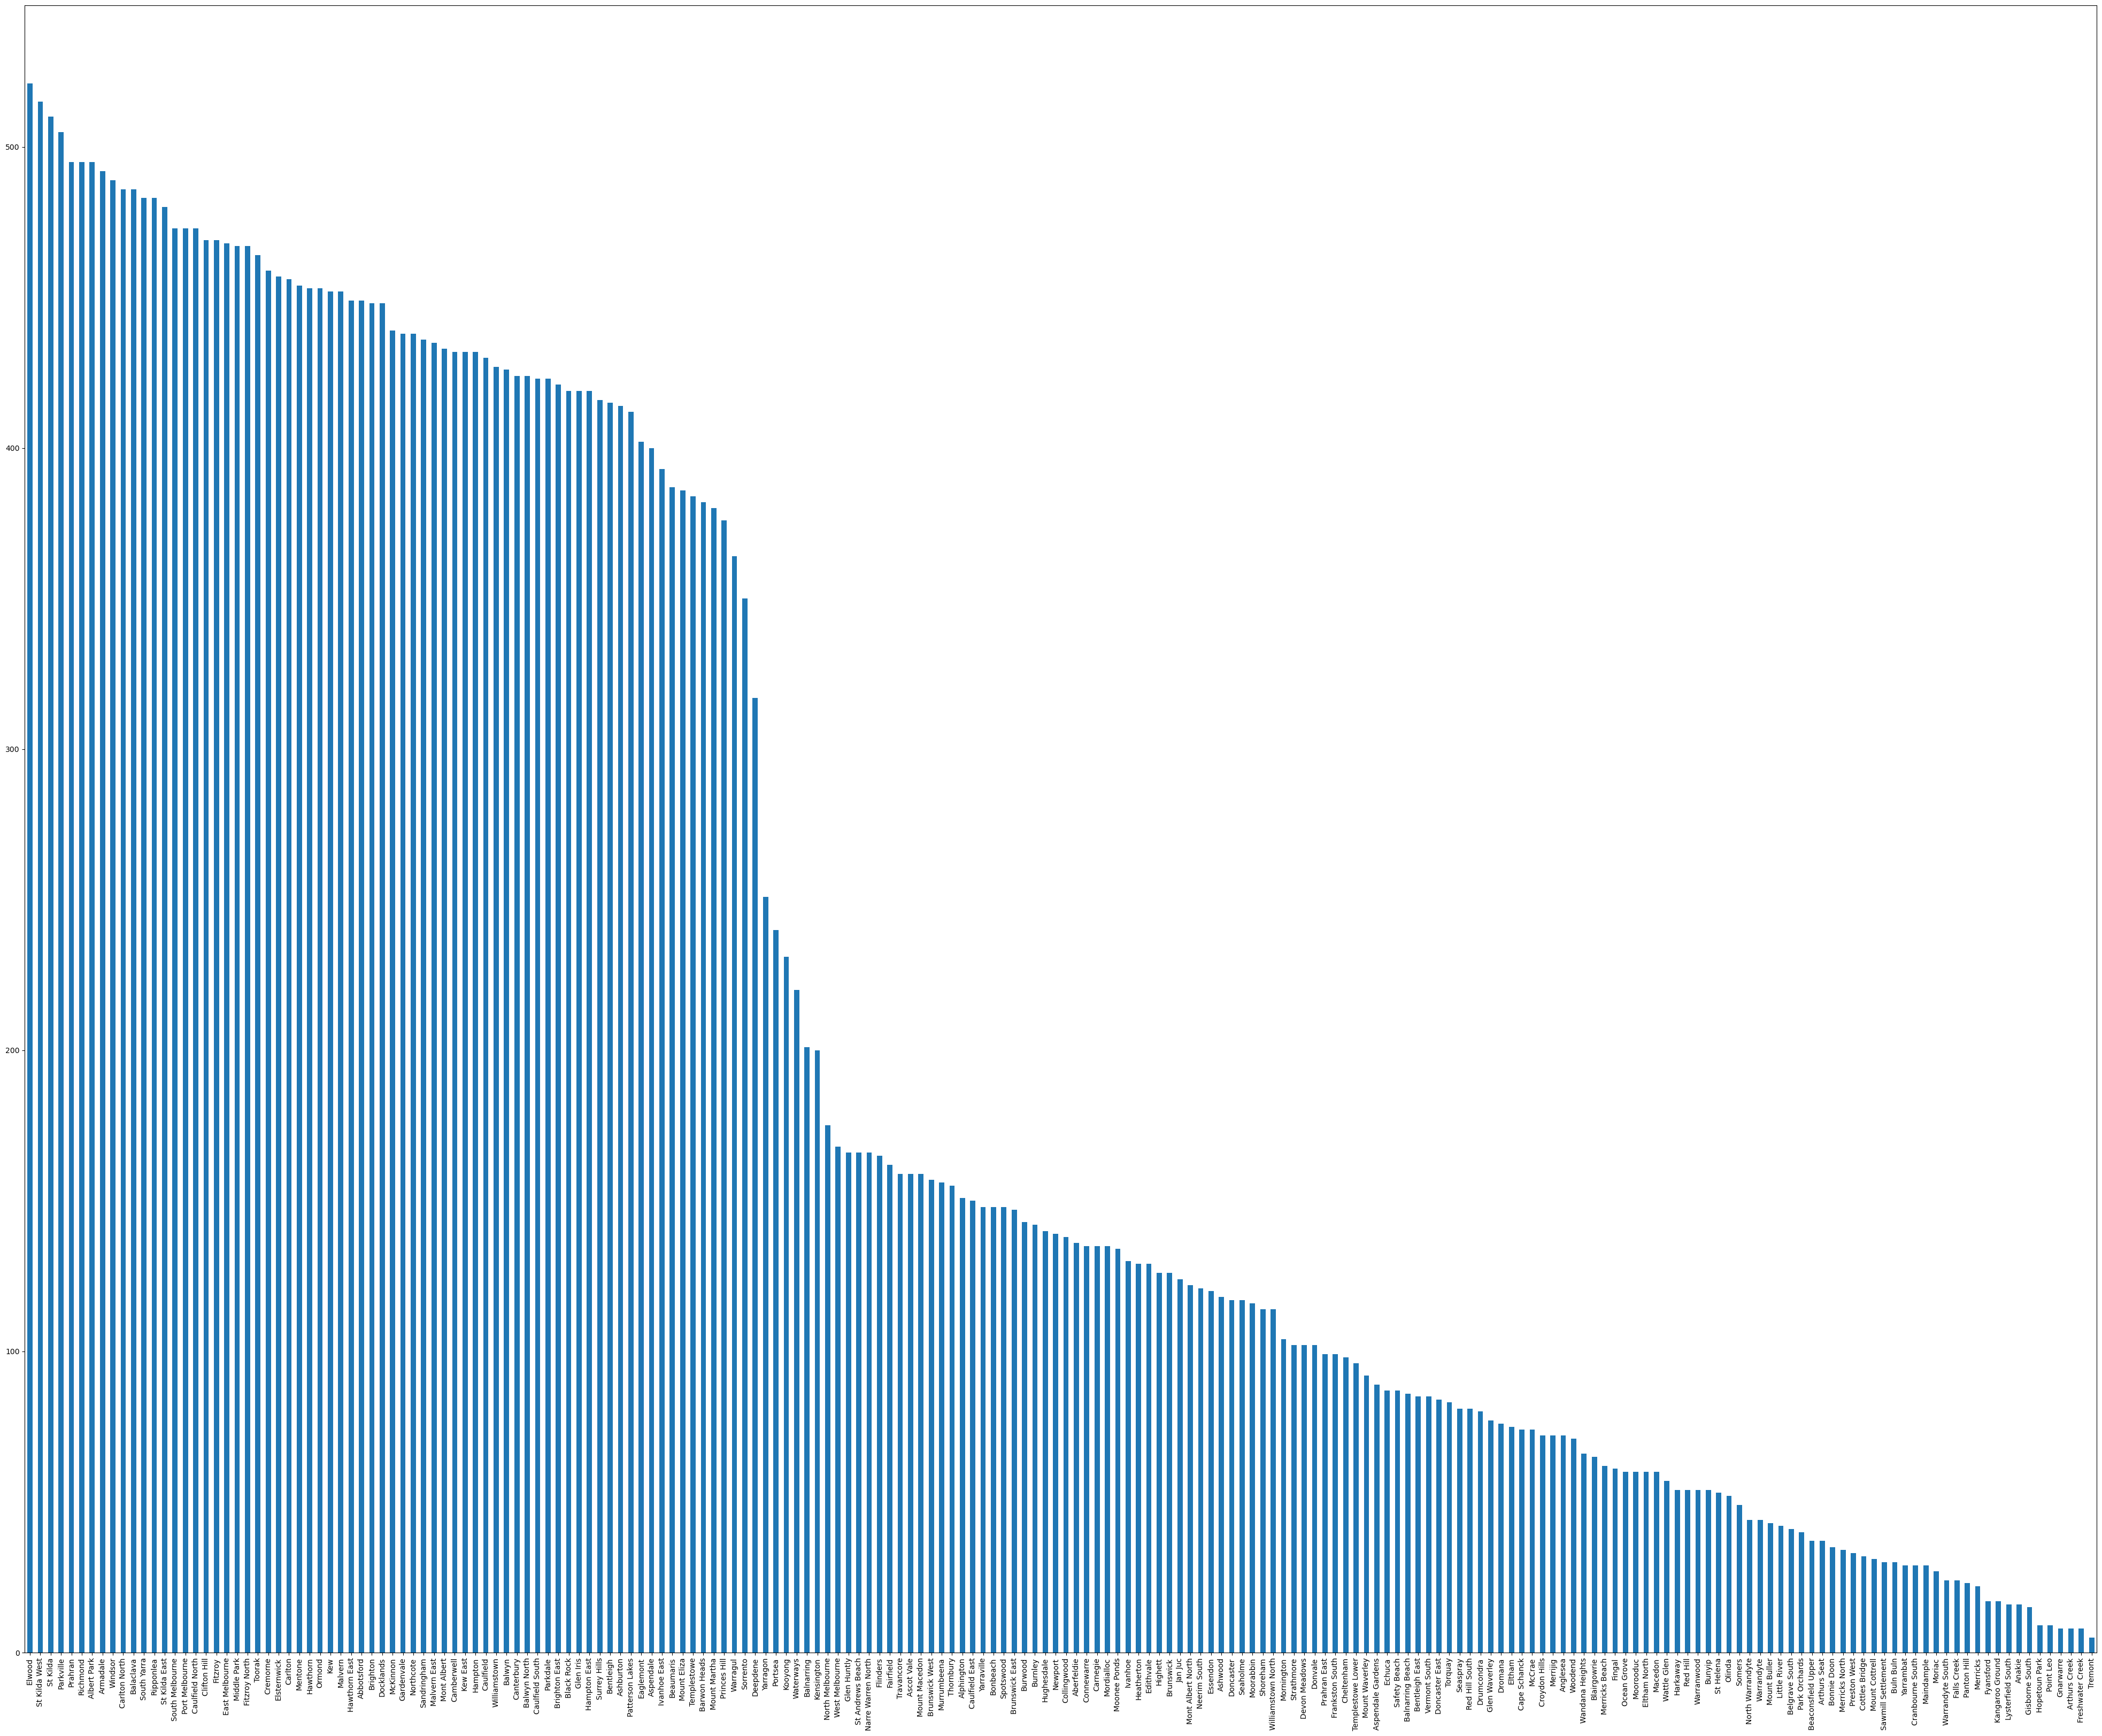

In [19]:
(df_property_filtered['suburb'].value_counts()).plot.bar(figsize=(50,40))

In [20]:
df_lga_suburb = pd.read_csv('../data/raw/suburbData.csv')

df_lga_suburb = df_lga_suburb[df_lga_suburb['STATE_NAME_2021'] == 'Victoria']
df_lga_suburb = df_lga_suburb[['SAL_NAME_2021', 'LGA_NAME_2021']]
df_lga_suburb = df_lga_suburb.drop_duplicates()
df_lga_suburb.replace('( \([^)]*\))', '', regex=True, inplace=True)

df_lga_suburb = df_lga_suburb.rename(columns={'SAL_NAME_2021': 'suburb', 'LGA_NAME_2021': 'Local Government Area'})

/tmp/ipykernel_5723/37332264.py:1: DtypeWarning: Columns (2,3,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lga_suburb = pd.read_csv('../data/raw/suburbData.csv')


In [30]:
df_rent = pd.merge(df_property_filtered, df_lga_suburb, how='left', on='suburb')
df_rent['Year'] = df_rent['rent_date'].dt.year

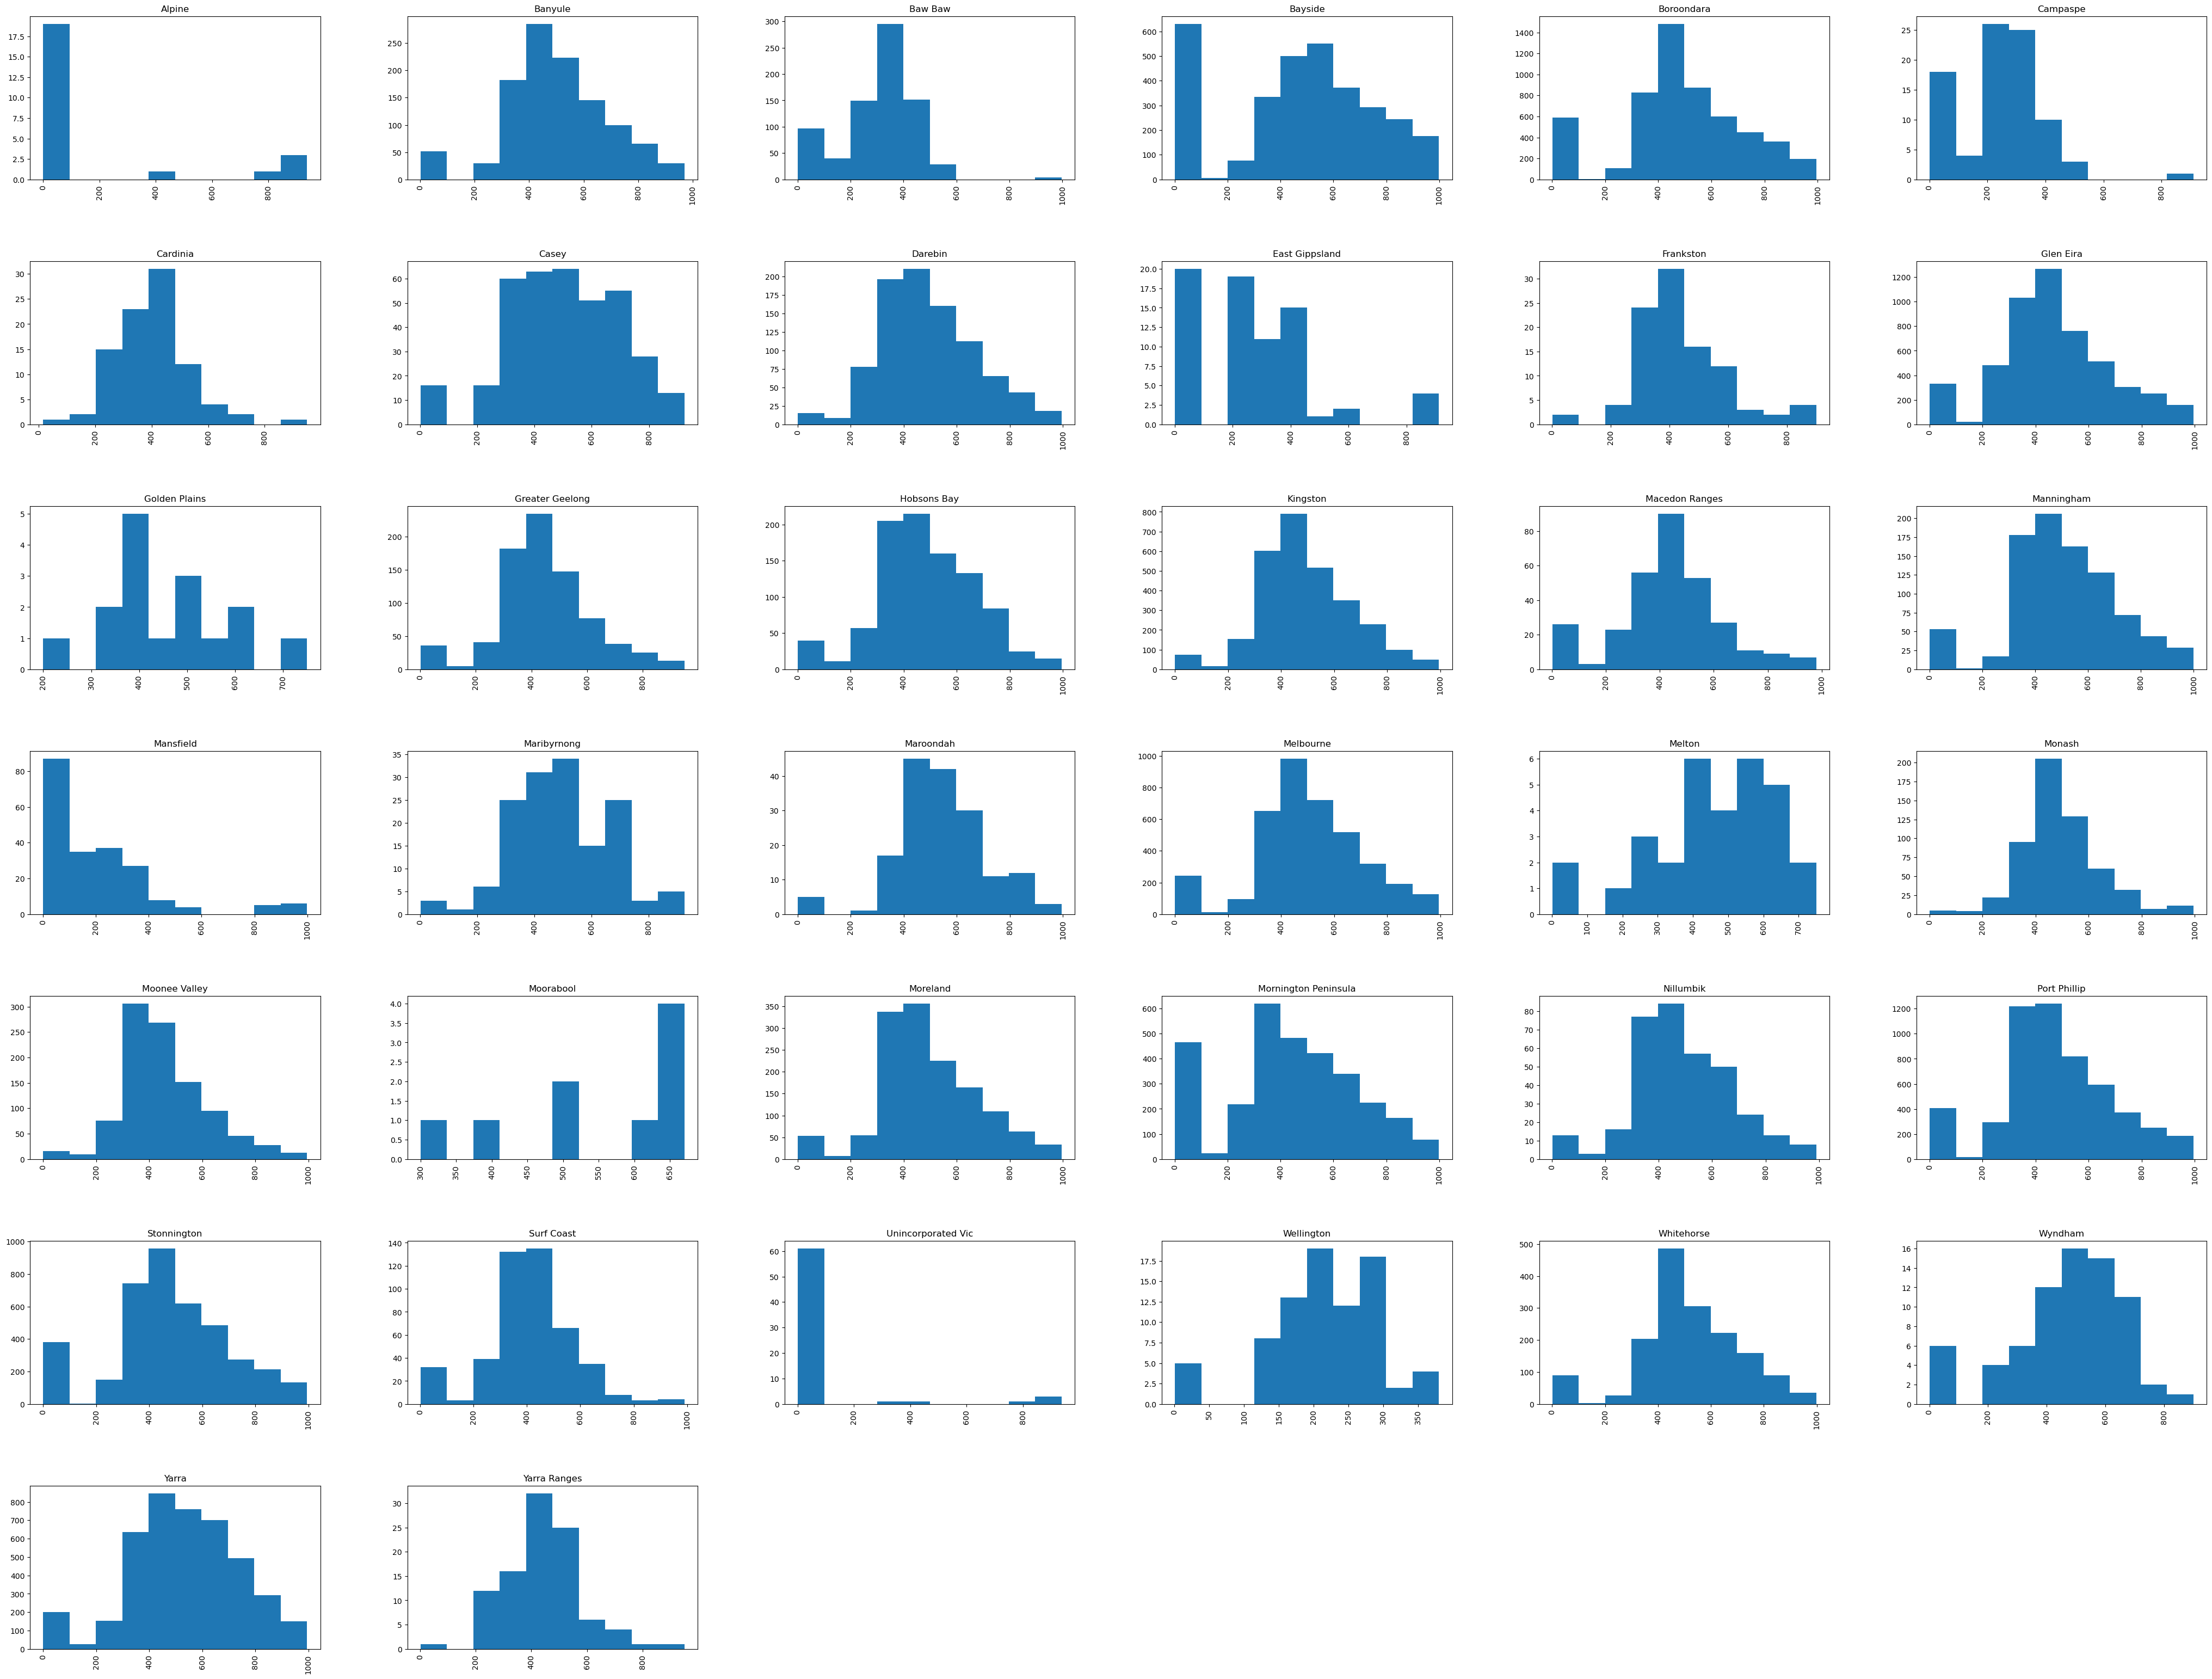

In [22]:
# hist rent by sal
histograms_rent_by_sal = df_rent[['Local Government Area', 'rent_price_']].hist(by=df_rent['Local Government Area'], figsize=(50,40))

In [32]:
df_rent = pd.merge(df_rent, df_Criminal_Incidents_LGA, how='left', on=['Year', 'Local Government Area'])
df_rent.dropna(inplace=True)

array([<AxesSubplot:title={'center':'rent_price_'}, xlabel='Local Government Area'>,
       <AxesSubplot:title={'center':'Rate per 100,000 population'}, xlabel='Local Government Area'>],
      dtype=object)

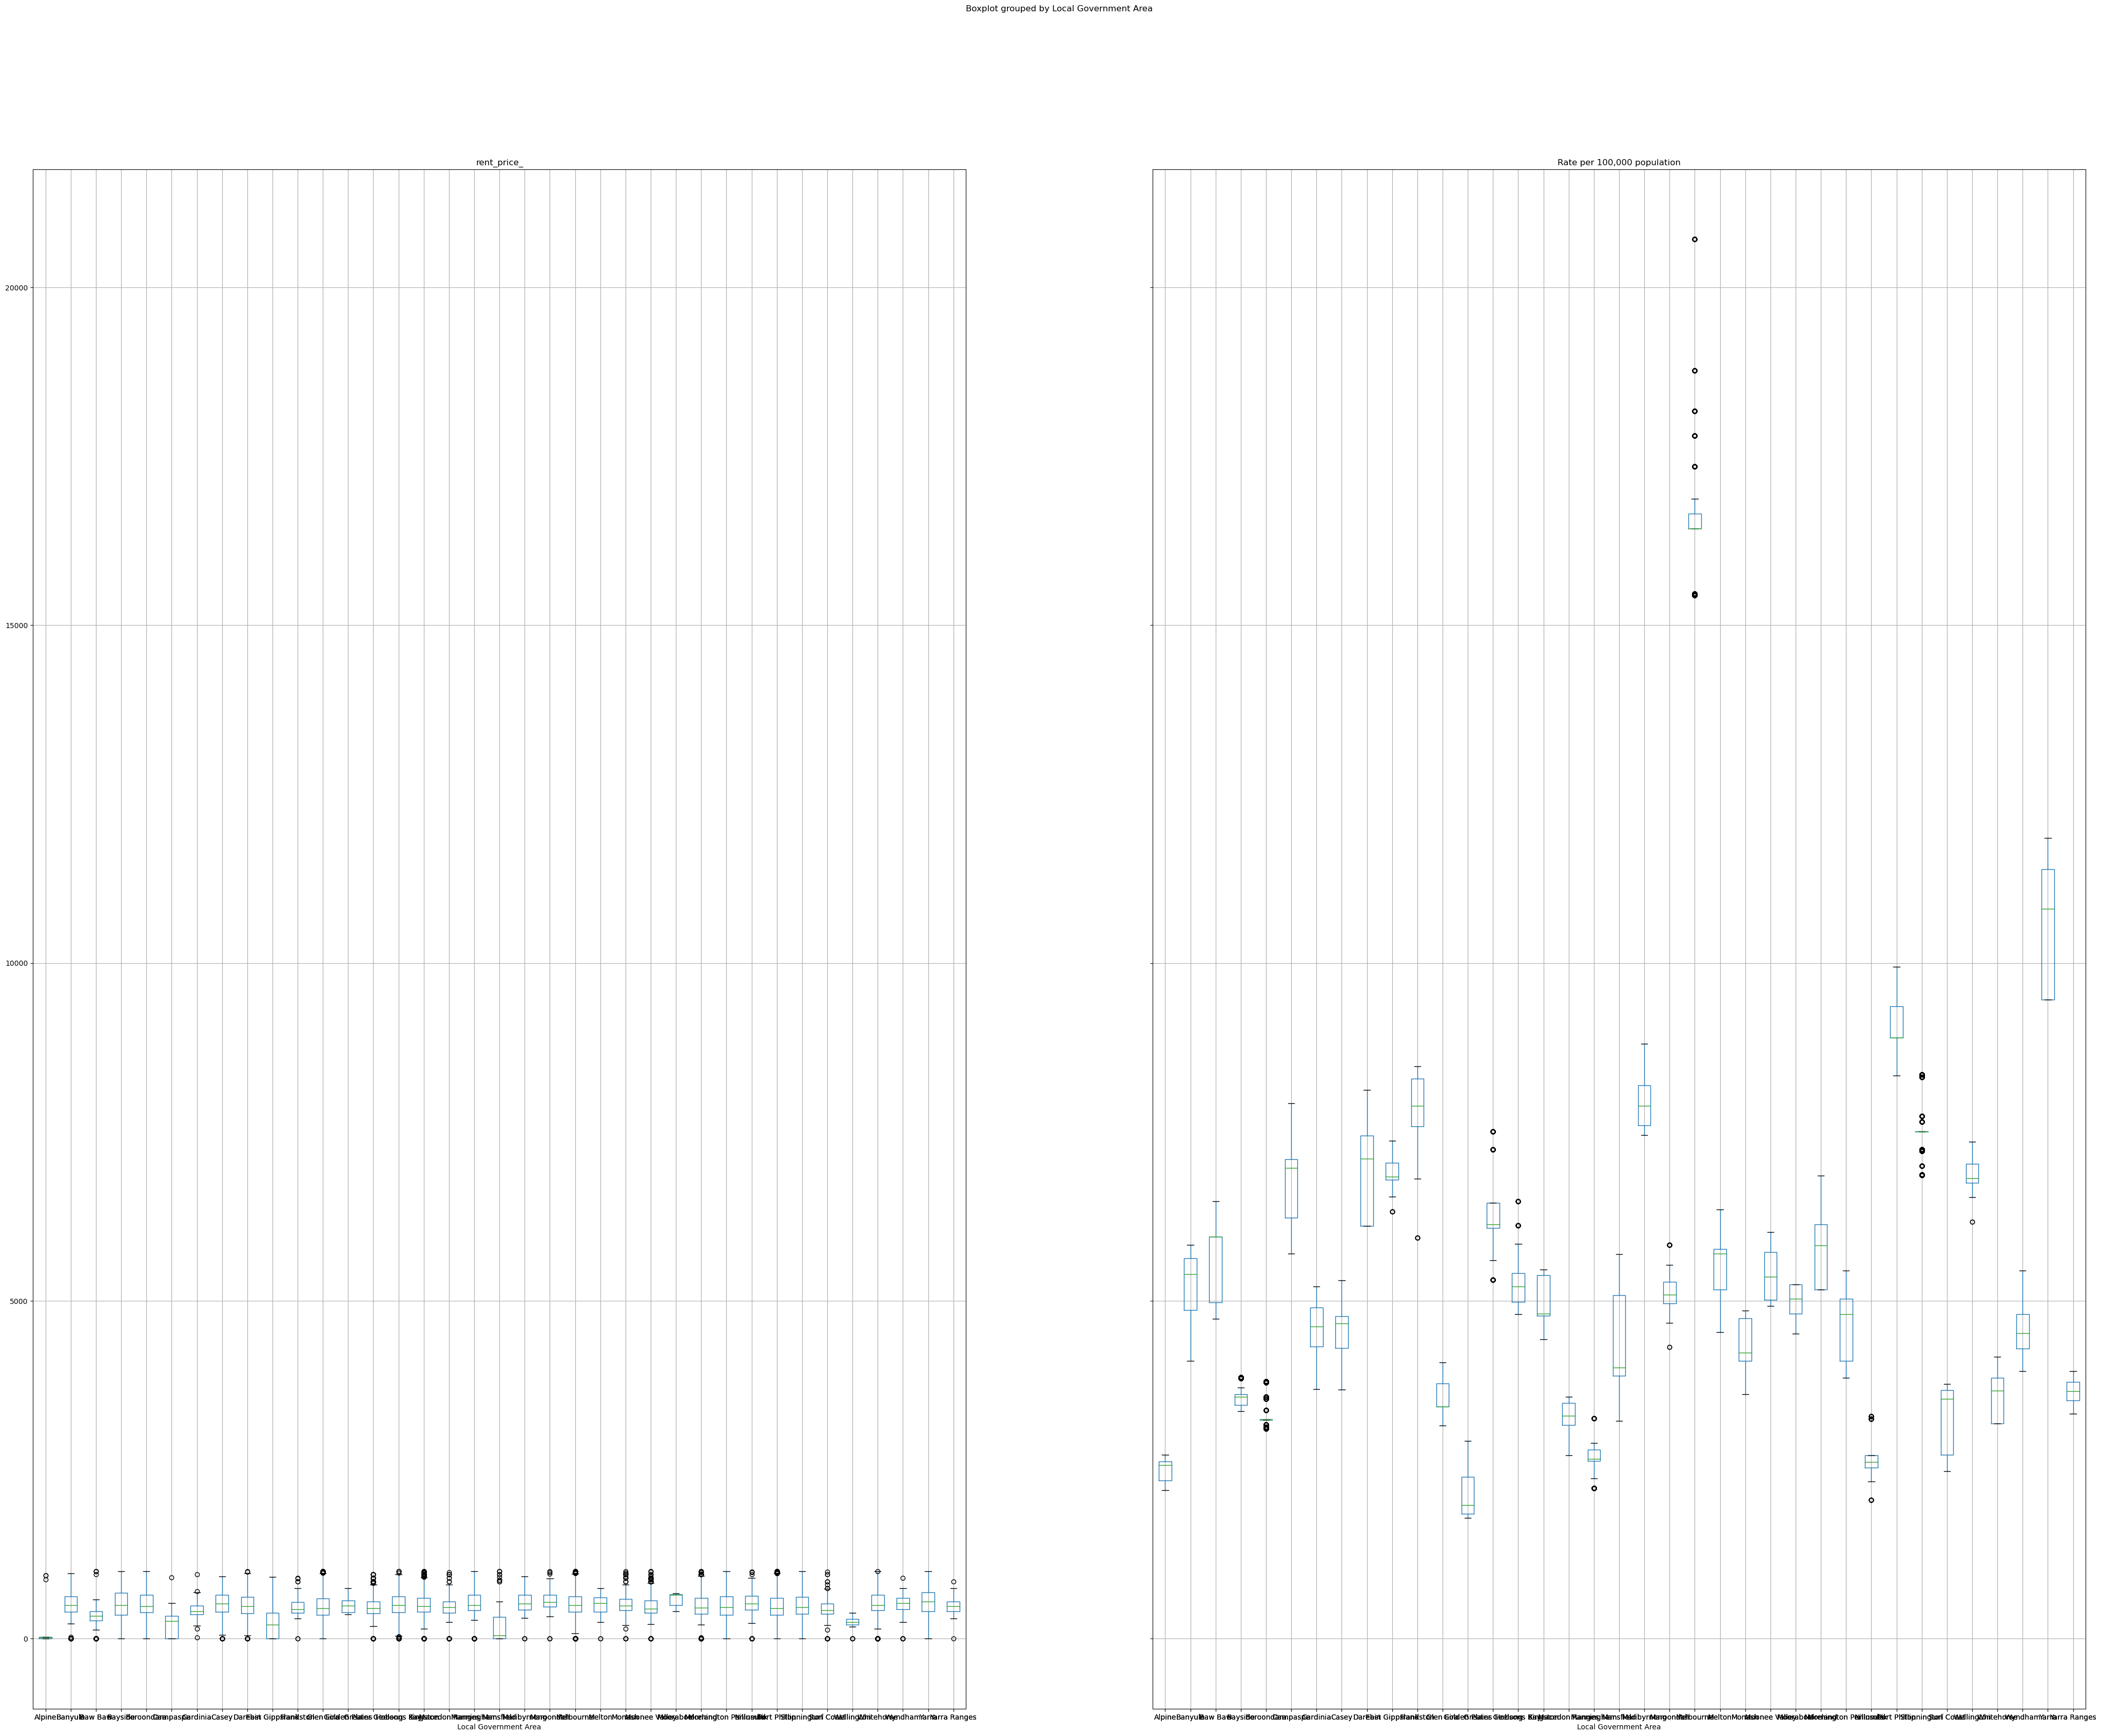

In [9]:
# boxplot
df_rent.boxplot(column=['rent_price_', 'Rate per 100,000 population'], by='Local Government Area',figsize=(50,40))


In [ ]:
df_rent.groupby(['Local Government Area', 'Year']).median()

In [34]:
df_rent_mean = df_rent.groupby(['Local Government Area', 'Year']).mean().reset_index()


/tmp/ipykernel_5723/602326790.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rent_mean = df_rent.groupby(['Local Government Area', 'Year']).mean().reset_index()


Year
2013    AxesSubplot(0.125,0.11;0.775x0.77)
2014    AxesSubplot(0.125,0.11;0.775x0.77)
2015    AxesSubplot(0.125,0.11;0.775x0.77)
2016    AxesSubplot(0.125,0.11;0.775x0.77)
2017    AxesSubplot(0.125,0.11;0.775x0.77)
2018    AxesSubplot(0.125,0.11;0.775x0.77)
2019    AxesSubplot(0.125,0.11;0.775x0.77)
2020    AxesSubplot(0.125,0.11;0.775x0.77)
2021    AxesSubplot(0.125,0.11;0.775x0.77)
2022    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

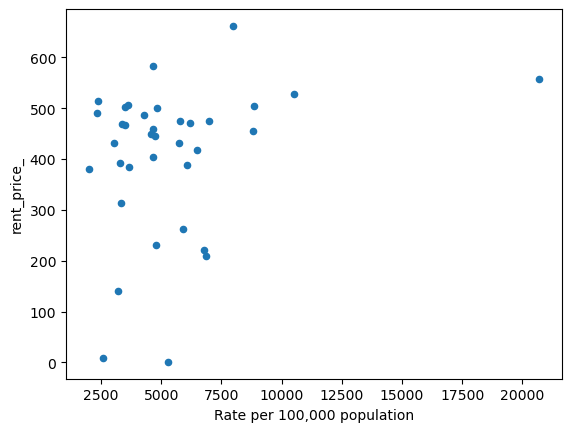

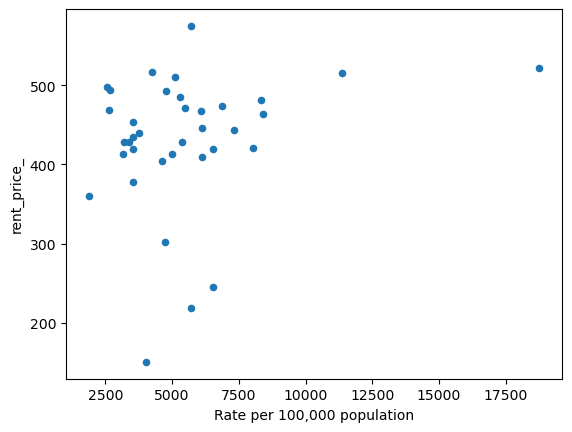

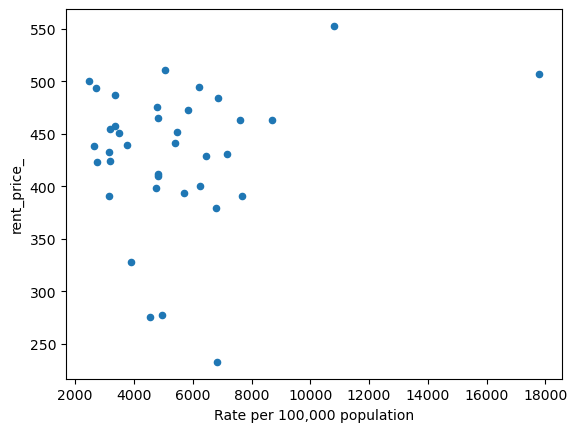

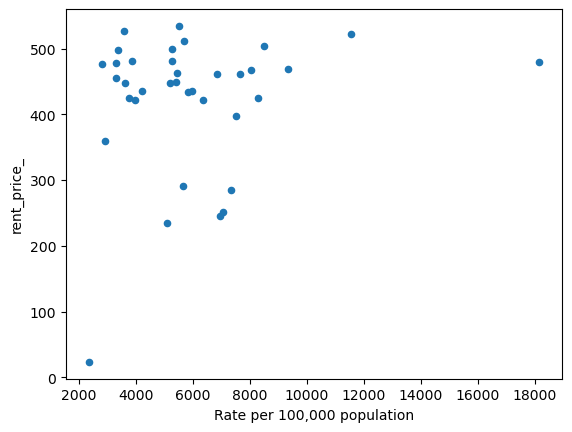

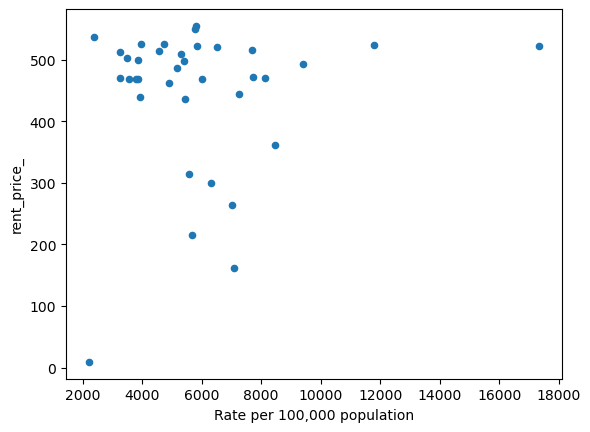

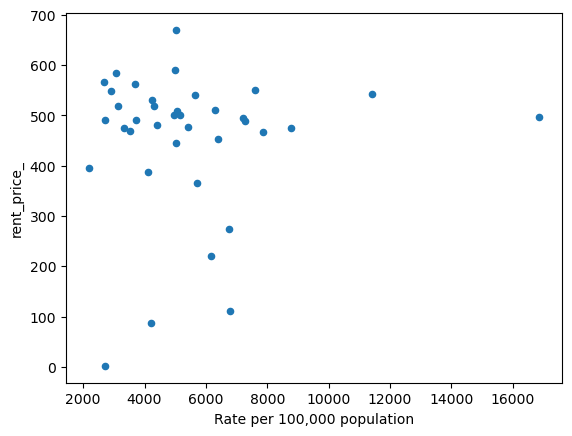

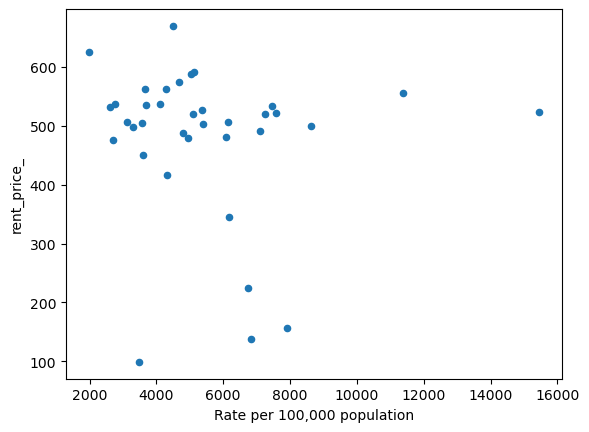

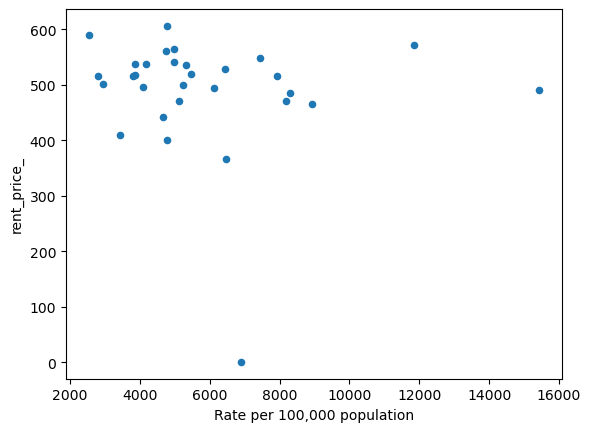

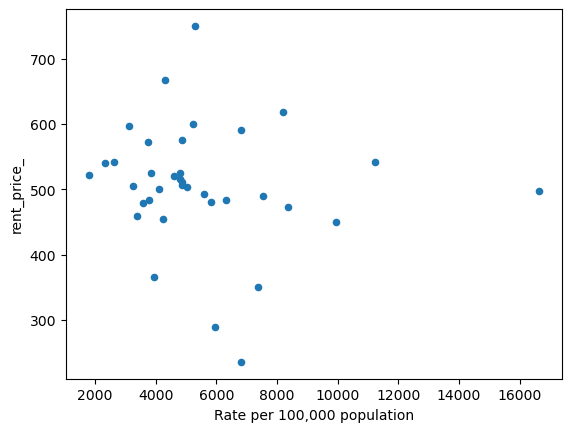

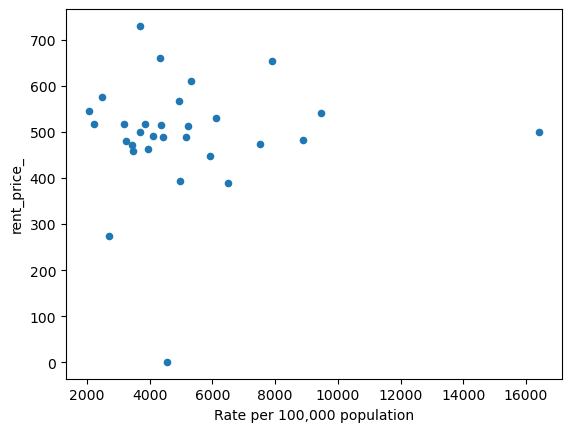

In [36]:
df_rent_mean.groupby('Year').plot.scatter(x='Rate per 100,000 population', y='rent_price_')

Year
2013    AxesSubplot(0.125,0.11;0.775x0.77)
2014    AxesSubplot(0.125,0.11;0.775x0.77)
2015    AxesSubplot(0.125,0.11;0.775x0.77)
2016    AxesSubplot(0.125,0.11;0.775x0.77)
2017    AxesSubplot(0.125,0.11;0.775x0.77)
2018    AxesSubplot(0.125,0.11;0.775x0.77)
2019    AxesSubplot(0.125,0.11;0.775x0.77)
2020    AxesSubplot(0.125,0.11;0.775x0.77)
2021    AxesSubplot(0.125,0.11;0.775x0.77)
2022    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

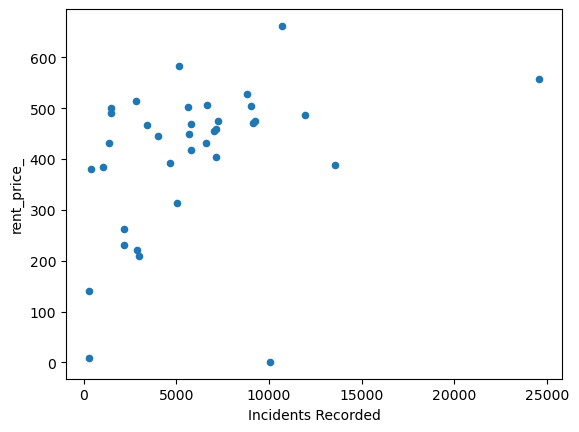

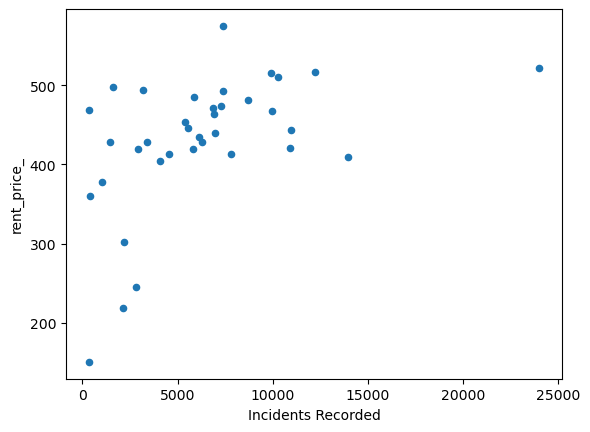

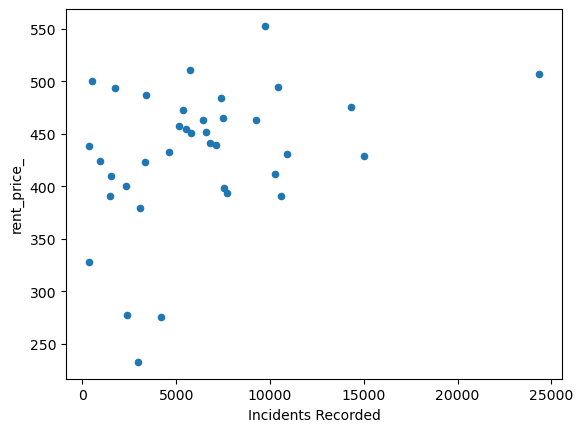

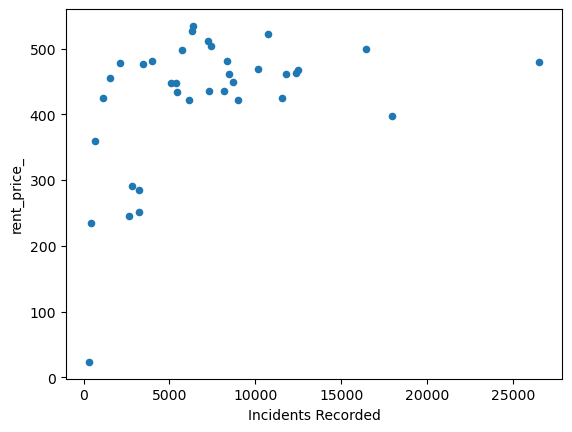

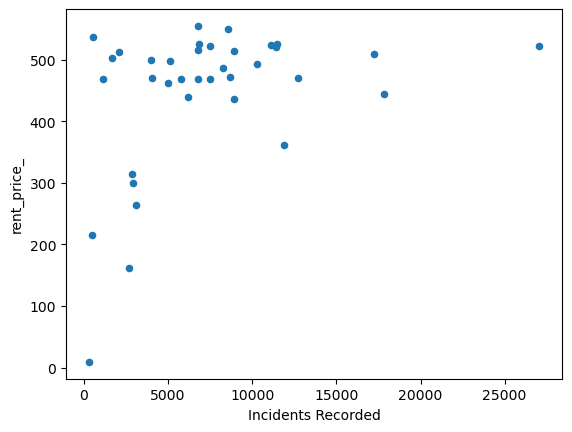

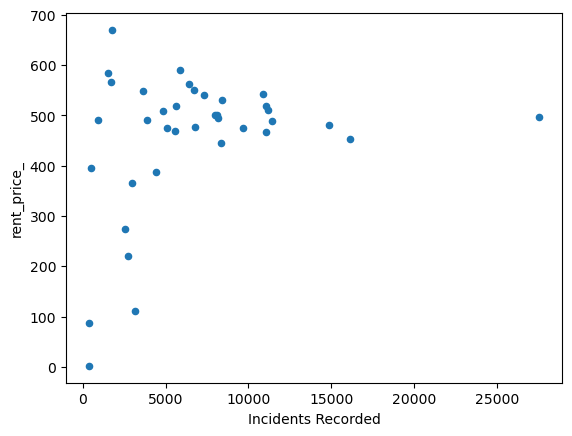

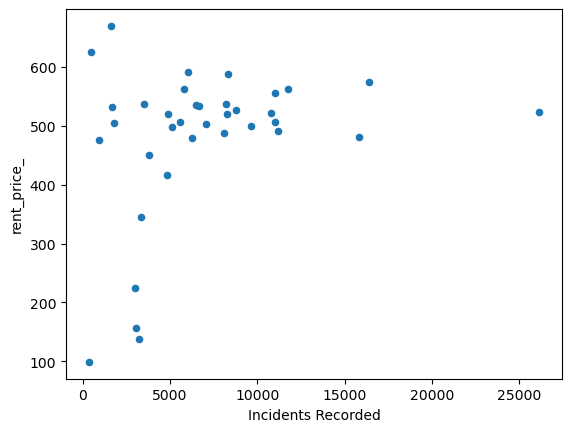

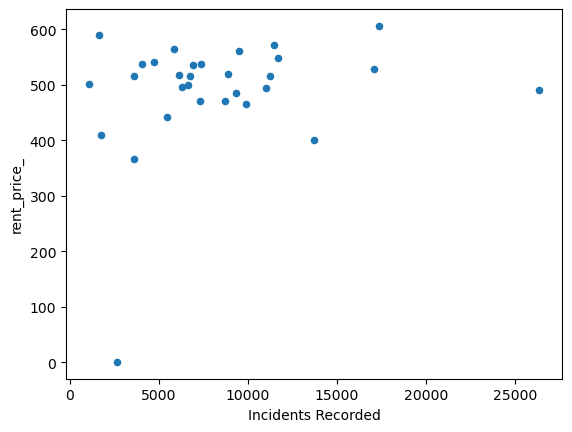

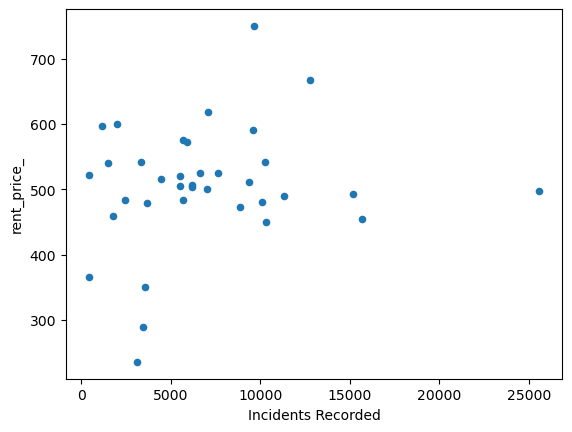

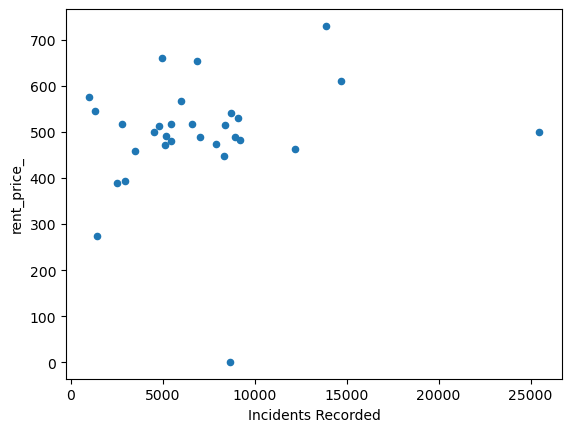

In [38]:
df_rent_mean.groupby('Year').plot.scatter(x='Incidents Recorded', y='rent_price_')

In [39]:
df_rent_median = df_rent.groupby(['Local Government Area', 'Year']).median().reset_index()

/tmp/ipykernel_5723/742540120.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rent_median = df_rent.groupby(['Local Government Area', 'Year']).median().reset_index()


Year
2013    AxesSubplot(0.125,0.11;0.775x0.77)
2014    AxesSubplot(0.125,0.11;0.775x0.77)
2015    AxesSubplot(0.125,0.11;0.775x0.77)
2016    AxesSubplot(0.125,0.11;0.775x0.77)
2017    AxesSubplot(0.125,0.11;0.775x0.77)
2018    AxesSubplot(0.125,0.11;0.775x0.77)
2019    AxesSubplot(0.125,0.11;0.775x0.77)
2020    AxesSubplot(0.125,0.11;0.775x0.77)
2021    AxesSubplot(0.125,0.11;0.775x0.77)
2022    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

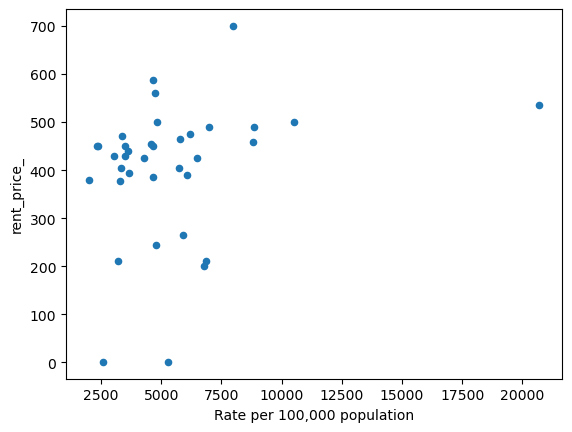

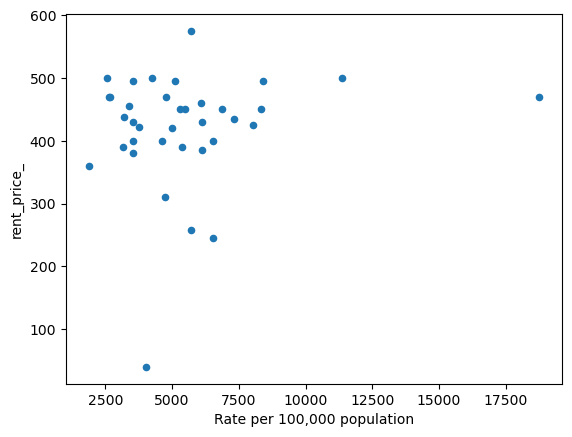

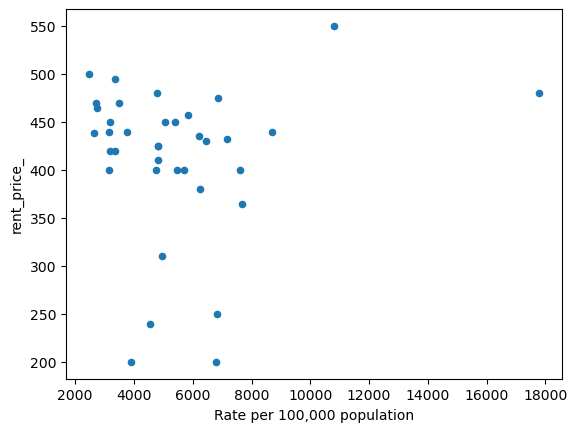

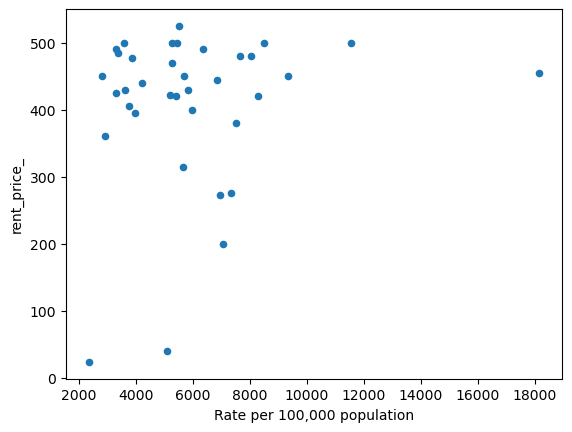

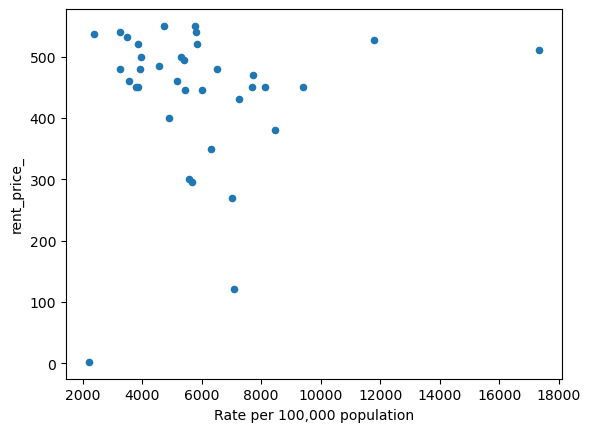

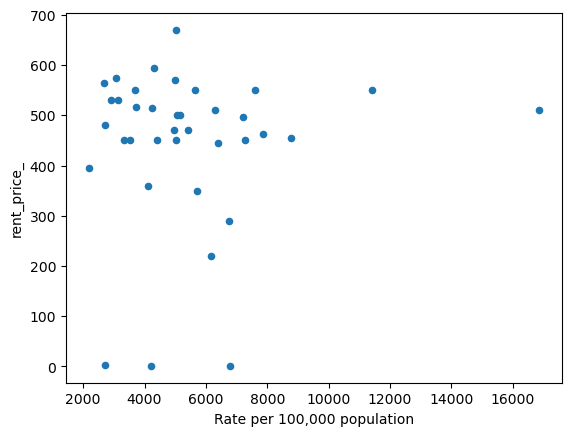

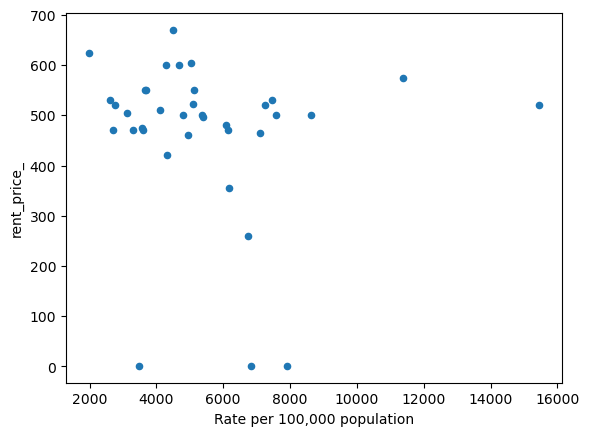

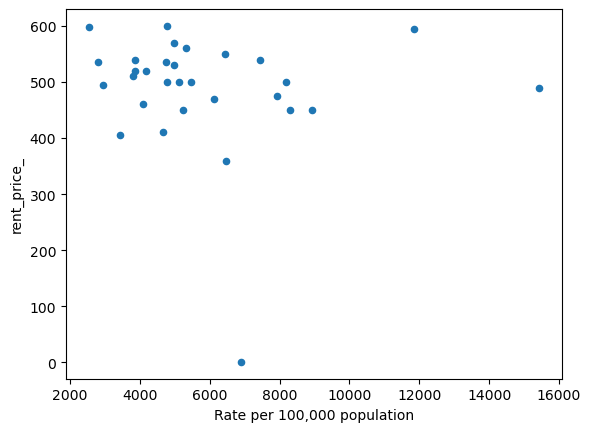

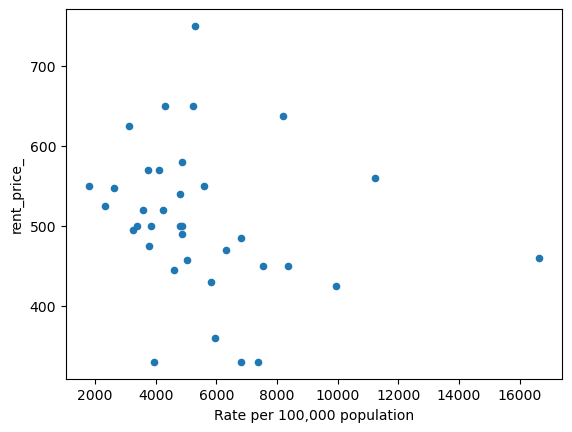

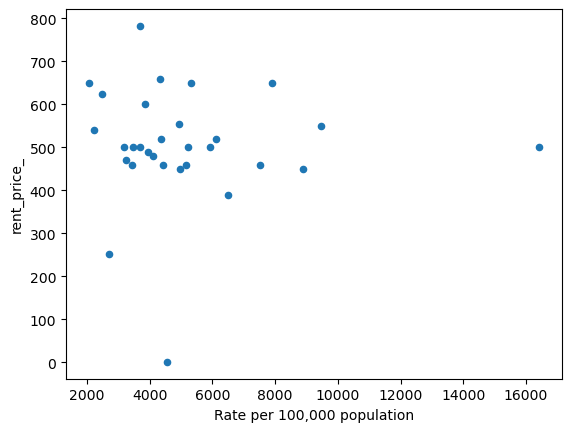

In [40]:
df_rent_median.groupby('Year').plot.scatter(x='Rate per 100,000 population', y='rent_price_')

Year
2013    AxesSubplot(0.125,0.11;0.775x0.77)
2014    AxesSubplot(0.125,0.11;0.775x0.77)
2015    AxesSubplot(0.125,0.11;0.775x0.77)
2016    AxesSubplot(0.125,0.11;0.775x0.77)
2017    AxesSubplot(0.125,0.11;0.775x0.77)
2018    AxesSubplot(0.125,0.11;0.775x0.77)
2019    AxesSubplot(0.125,0.11;0.775x0.77)
2020    AxesSubplot(0.125,0.11;0.775x0.77)
2021    AxesSubplot(0.125,0.11;0.775x0.77)
2022    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

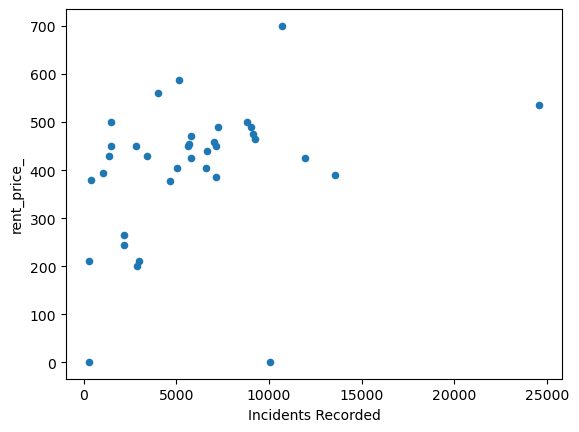

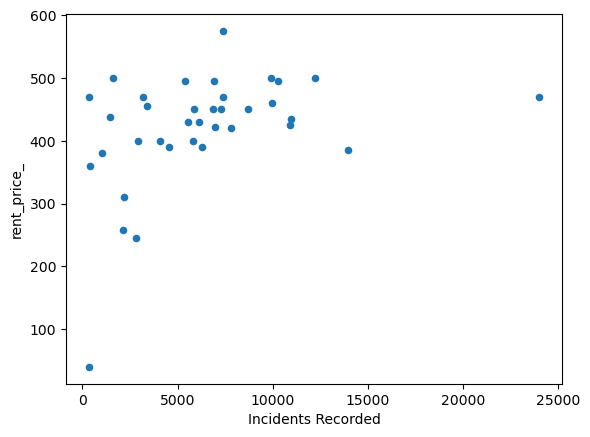

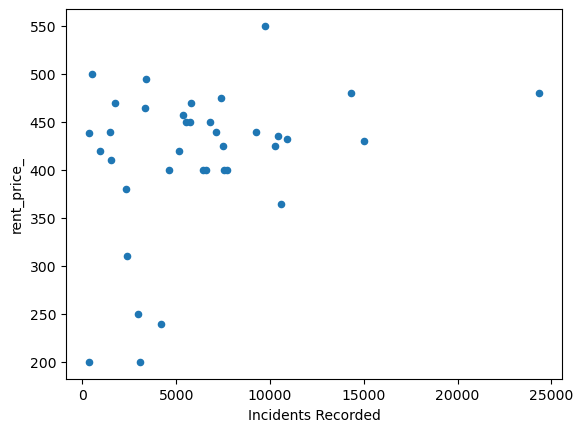

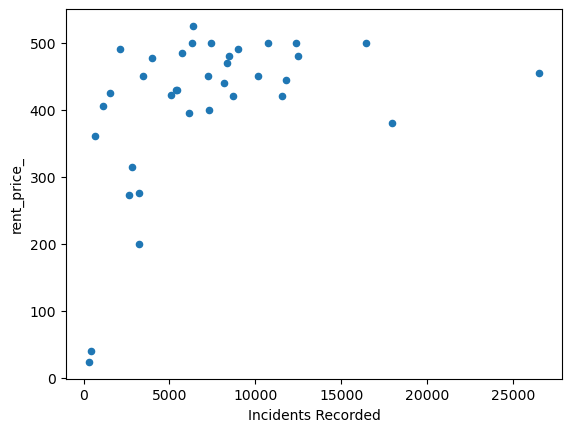

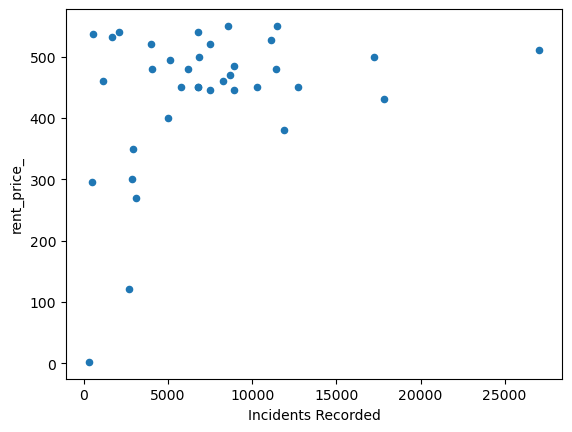

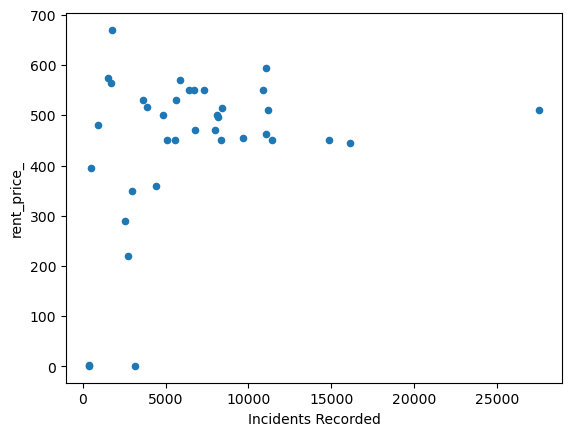

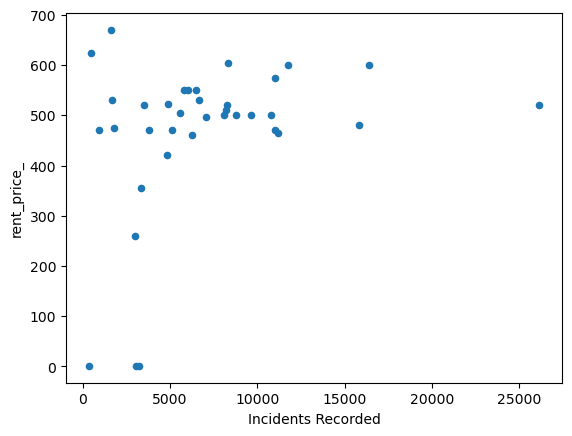

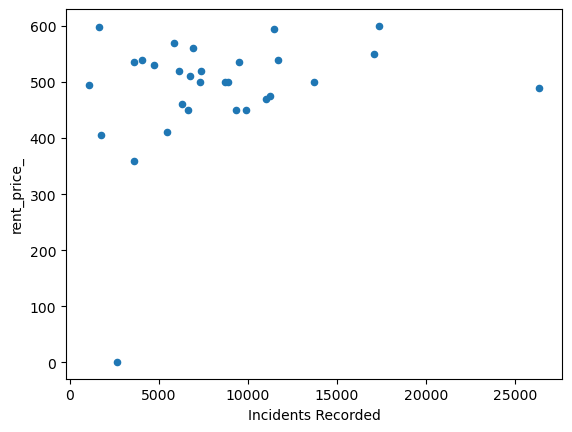

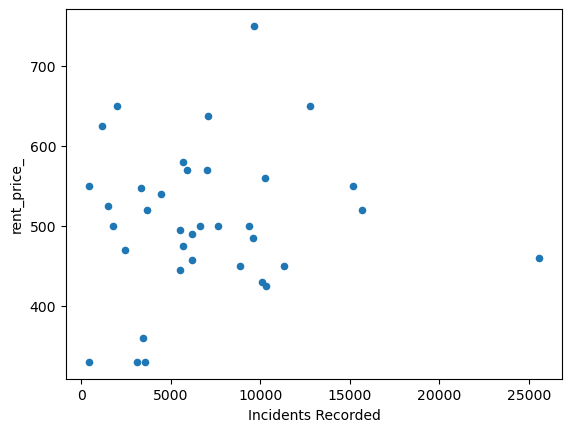

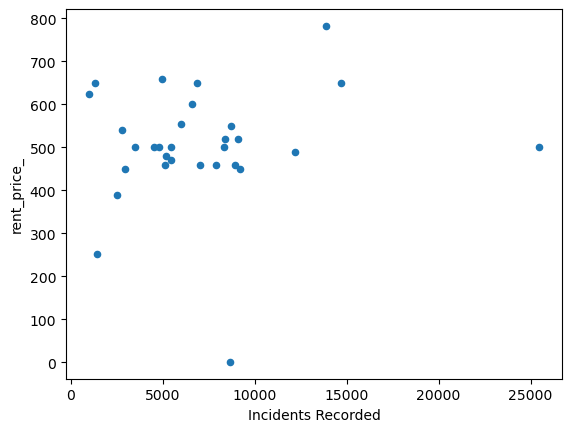

In [41]:
df_rent_median.groupby('Year').plot.scatter(x='Incidents Recorded', y='rent_price_')

# Conclusion:
from the plots above, no clear correlationship can be found between the crime rate or total incident and rent price